In [1]:
import sys
from pathlib import Path
sys.path.append("..\..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import trange
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import auc, roc_curve

from src.data.datasets.overlaps import OverlapsDataset

C:\Temp\ipykernel_7300\2583795483.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
dataset = OverlapsDataset.from_path("..\\..\\datasets\\PlagiNet")

Extracting non-overlapping features: 100%|██████████| 760/760 [00:23<00:00, 32.90it/s]


In [3]:
df = pd.DataFrame(
    np.concatenate([dataset.features, dataset.targets.reshape(-1, 1)], axis=1), 
    columns=dataset.feature_names + ['is_overlapping']
)
df

,levenshtein_distance,match_len1,match_len2,match_ratio1,match_ratio2,note_C,note_C♯,note_D,note_D♯,note_E,...,interval_6,interval_7,interval_8,interval_9,interval_10,interval_lt,interval_gt,interval_to_rest,interval_from_rest,is_overlapping
0,0.235290,-0.506027,-0.508394,-0.562391,-0.563156,-0.525179,-0.721058,-0.441421,-0.668382,-0.912110,...,-0.407332,0.014410,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-1.004430,-1.004430,1.0
1,-1.185390,1.146240,0.846692,1.409168,0.263556,-0.914570,0.333407,-0.587439,-0.668382,-0.510787,...,-0.407332,0.991754,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-0.347445,-0.347445,1.0
2,-1.181321,2.417214,0.969882,2.598739,2.565198,-0.135788,-0.325633,-1.025490,-0.136766,-0.611117,...,2.455000,-0.474263,1.869871,-0.271666,-0.328564,-0.473907,-0.365269,-1.332923,-1.332923,1.0
3,-1.176717,0.193009,3.864841,-0.083391,2.257328,3.238934,-0.193825,-0.295404,0.394850,-0.912110,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,2.436703,-0.365269,0.966527,0.966527,1.0
4,1.622277,-0.506027,-0.508394,-0.562391,-0.563156,1.681370,-0.721058,-0.295404,-0.668382,0.592852,...,-0.407332,0.991754,0.106268,4.295141,3.043544,-0.473907,2.416274,-1.332923,-1.332923,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,-0.032375,-0.506027,-0.508394,-0.562391,-0.563156,-0.525179,-0.721058,0.580699,-0.668382,-0.410456,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-1.332923,-1.332923,0.0
776,-0.032375,-0.506027,-0.508394,-0.562391,-0.563156,-0.914570,-0.589250,-1.025490,-0.668382,-0.912110,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-0.018952,-0.018952,0.0
777,-0.032375,-0.506027,-0.508394,-0.562391,-0.563156,-0.914570,-0.589250,-1.025490,-0.668382,-0.912110,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-0.018952,-0.018952,0.0
778,-0.032375,-0.506027,-0.508394,-0.562391,-0.563156,-0.914570,0.201599,-1.025490,0.040439,-0.912110,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-0.018952,-0.018952,0.0


In [13]:
positive_count = int(np.sum(dataset.targets == 1))
negative_count = int(np.sum(dataset.targets == 0))

pos_weight = negative_count / positive_count if positive_count > 0 else 1.0
neg_weight = positive_count / negative_count if negative_count > 0 else 1.0

print(f"neg_weight: {neg_weight}")
print(f"pos_weight: {pos_weight}")

neg_weight: 0.02631578947368421
pos_weight: 38.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset.features, dataset.targets, test_size=0.2, random_state=42, stratify=dataset.targets)

In [5]:
classifiers = {
    'Логистическая регрессия': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'LDA': LDA(),
    'SVM': svm.SVC(kernel='poly', class_weight='balanced', probability=True, random_state=42),
    'Дерево решений': DecisionTreeClassifier(class_weight='balanced', max_depth=1, random_state=42),
    'Случайный лес': RandomForestClassifier(class_weight='balanced', max_depth=1, random_state=42),
    'Градиентный бустинг': GradientBoostingClassifier(max_depth=1, random_state=42)
}

In [6]:
def calculate_metrics(
    X_test: np.ndarray,
    y_test: np.ndarray,
    classifier: BaseEstimator,
    n_bootstrap: int = 1000,
    seed: int = 42
) -> dict[str, dict[str, list[float]]]:
    """Вычисляет precision, recall и auc с доверительными интервалами на разных порогах с помощью стратифицированного бутстрапа.

    :param np.ndarray X_test: Массив признаков
    :param np.ndarray y_test: Массив целевых значений
    :param BaseEstimator classifier: Классификатор
    :param int n_bootstrap: Количество итераций бутстрапа
    :param int seed: Сид для генератора случайных чисел

    :return dict[str, dict[str, list[float]]]: Словарь auc и roc
    """
    rng = np.random.default_rng(seed)
    metrics = {
        "auc": {"mean": None, "lower": None, "upper": None},
        "roc": {"fpr": [], "tpr_mean": [], "tpr_lower": [], "tpr_upper": []}
    }

    fpr_lin = np.linspace(0, 1, 100)
    tpr_boot = []
    aucs = []

    pos_indices = np.where(y_test == 1)[0]
    neg_indices = np.where(y_test == 0)[0]
    
    n_pos = len(pos_indices)
    n_neg = len(neg_indices)
    

    for _ in trange(n_bootstrap, desc="Расчет AUC с доверительными интервалами"):

        boot_pos_indices = rng.choice(pos_indices, size=n_pos, replace=True)
        boot_neg_indices = rng.choice(neg_indices, size=n_neg, replace=True)
        
        boot_indices = np.concatenate([boot_pos_indices, boot_neg_indices])
        
        rng.shuffle(boot_indices)
        
        X_boot = X_test[boot_indices]
        y_boot = y_test[boot_indices]
        
        if len(np.unique(y_boot)) < 2:
            continue
        
        y_pred_proba = classifier.predict_proba(X_boot)[:, 1]
        fpr_i, tpr_i, _ = roc_curve(y_boot, y_pred_proba)
        auc_val = auc(fpr_i, tpr_i)

        aucs.append(auc_val)
        
        interp_tpr = np.interp(fpr_lin, fpr_i, tpr_i)
        interp_tpr[0] = 0.0
        tpr_boot.append(interp_tpr)

    aucs = np.array(aucs)
    metrics["auc"]["mean"] = aucs.mean()
    metrics["auc"]["lower"] = np.percentile(aucs, 2.5)
    metrics["auc"]["upper"] = np.percentile(aucs, 97.5)

    tpr_boot = np.array(tpr_boot)
    metrics["roc"]["fpr"] = fpr_lin
    metrics["roc"]["tpr_mean"] = tpr_boot.mean(axis=0)
    metrics["roc"]["tpr_lower"] = np.percentile(tpr_boot, 2.5, axis=0)
    metrics["roc"]["tpr_upper"] = np.percentile(tpr_boot, 97.5, axis=0)

    return metrics

Расчет AUC с доверительными интервалами: 100%|██████████| 1000/1000 [00:00<00:00, 1404.62it/s]


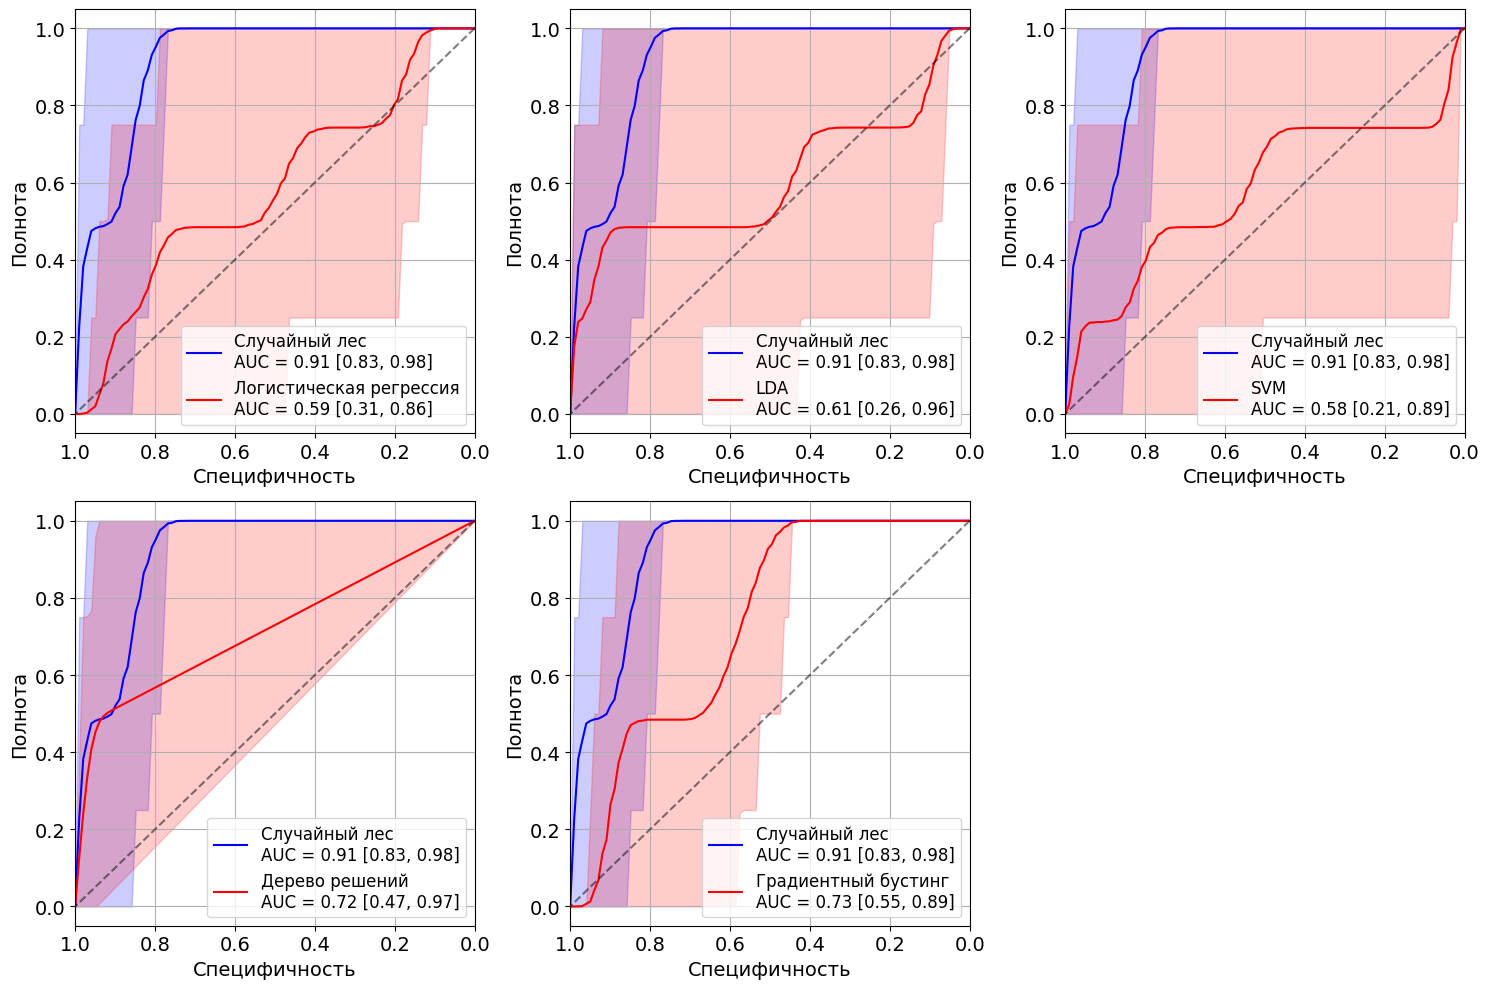

In [10]:
colors = ['blue', 'red']
ci_alpha = 0.2
labels_fontsize=14
legend_fontsize=12
title_fontsize=16
ticks_fontsize=14

rf_classifier = classifiers['Случайный лес']
rf_classifier.fit(X_train, y_train)
rf_metrics = calculate_metrics(X_test, y_test, rf_classifier)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plot_idx = 0
for i, (matcher_title, matcher_class) in enumerate(classifiers.items()):

    if matcher_title != 'Случайный лес':
        ax = axes[plot_idx]
        plot_idx += 1
        
        mean_auc = rf_metrics["auc"]["mean"]
        lower_auc = rf_metrics["auc"]["lower"]
        upper_auc = rf_metrics["auc"]["upper"]
        fpr = rf_metrics["roc"]["fpr"]
        tpr_mean = rf_metrics["roc"]["tpr_mean"]
        tpr_lower = rf_metrics["roc"]["tpr_lower"]
        tpr_upper = rf_metrics["roc"]["tpr_upper"]
        
        ax.plot(1-fpr, tpr_mean, label=f"Случайный лес\nAUC = {mean_auc:.2f} [{lower_auc:.2f}, {upper_auc:.2f}]", color=colors[0])
        ax.fill_between(1-fpr, tpr_lower, tpr_upper, alpha=ci_alpha, color=colors[0])
        
        matcher_class.fit(X_train, y_train)
        matcher_metrics = calculate_metrics(X_test, y_test, matcher_class)
        
        mean_auc = matcher_metrics["auc"]["mean"]
        lower_auc = matcher_metrics["auc"]["lower"]
        upper_auc = matcher_metrics["auc"]["upper"]
        fpr = matcher_metrics["roc"]["fpr"]
        tpr_mean = matcher_metrics["roc"]["tpr_mean"]
        tpr_lower = matcher_metrics["roc"]["tpr_lower"]
        tpr_upper = matcher_metrics["roc"]["tpr_upper"]
        
        ax.plot(1-fpr, tpr_mean, label=f"{matcher_title}\nAUC = {mean_auc:.2f} [{lower_auc:.2f}, {upper_auc:.2f}]", color=colors[1])
        ax.fill_between(1-fpr, tpr_lower, tpr_upper, alpha=ci_alpha, color=colors[1])
        
        ax.plot([0, 1], [1, 0], color="black", linestyle="--", alpha=0.5)
        ax.set_xlabel("Специфичность", fontsize=labels_fontsize)
        ax.set_ylabel("Полнота", fontsize=labels_fontsize)
        ax.set_xlim((1, 0))
        ax.legend(loc="lower right", fontsize=legend_fontsize)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

axes[-1].axis('off')
plt.tight_layout()